In [4]:
import xarray as xr 
import numpy as np

import sys
sys.path.append('/home/users/cturrell/documents/eddy_feedback')
import functions.data_wrangling as data
import functions.eddy_feedback as ef

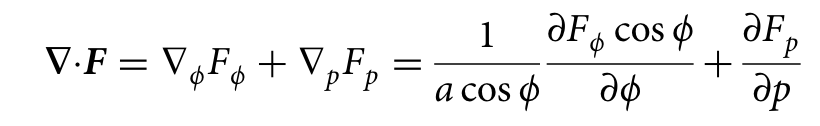

# SPARC SRIP Data

- EPF_phi_pr (epfy) = [m3 s-2]
- EPFD_phi_pr (div1) = [m s-2]

In [5]:
srip = xr.open_mfdataset('/badc/srip/data/zonal/common_grid/jra_55/TEM_monthly*')
# srip = srip.interp( latitude = np.arange(-90, 93, 3) )
srip

<xarray.Dataset>
Dimensions:         (time: 708, pressure: 22, latitude: 73)
Coordinates:
  * time            (time) datetime64[ns] 1958-01-14T09:00:00 ... 2016-12-14T...
  * pressure        (pressure) float32 1e+03 925.0 850.0 700.0 ... 3.0 2.0 1.0
  * latitude        (latitude) float32 -90.0 -87.5 -85.0 ... 85.0 87.5 90.0
Data variables: (12/37)
    EPF_p_qg        (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_phi_qg      (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_p_qg       (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_qg     (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_p_pr        (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_phi_pr      (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    ...              ...
    EPFD_p_qg_k3    (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_qg_k3  (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_p_pr_k3     (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_phi_pr_k3   (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_p_pr_k3    (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_pr_k3  (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
Attributes:
    Title:                     Transformed Eulerian Mean (TEM) diagnostics / ...
    Description:               EP flux and other terms from the TEM equations...
    Reanalysis:                jra_55
    Project_Homepage:          http://s-rip.ees.hokudai.ac.jp/
    SPARC_Homepage:            http://www.sparc-climate.org/
    Author:                    Patrick Martineau
    Report_issues_with_data:   patrick.martineau2@mail.mcgill.ca
    Creation_Date:             15-Oct-2017 09:41:14
    history:                   Sun Oct 15 09:41:14 2017: ncra /data/A/SRIP_da...
    nco_openmp_thread_number:  1